# FIT plt

This notebook aims to develop a single function to compute the translation and rotation data for the concave T0C+ detector array. 

For more information, see my senior project at [Cal Poly Digital Commons](http://digitalcommons.calpoly.edu/physsp/150/)

## FITC Geometry Function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import display

/Users/nmille16/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def conc(r, s): #r = radius of array, s = width of single detector
    dP = s/2
    theta = 2*np.arctan(dP/r)
    #Translations 
    n = [-3,-2,-1,1,2,3]
    gridpoints = []
    for i in n:
        gridpoints.append(r*np.sin((1-1/(2*abs(i)))*i*theta))
        
    xi = np.array([gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],
       gridpoints[0],gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],gridpoints[5],
       gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4]])
    yi = np.array([gridpoints[5],gridpoints[5],gridpoints[5],gridpoints[5],
       gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],
       gridpoints[3],gridpoints[3],gridpoints[3],gridpoints[3],
       gridpoints[2],gridpoints[2],gridpoints[2],gridpoints[2],
       gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],
       gridpoints[0],gridpoints[0],gridpoints[0],gridpoints[0]])
    
    zi = np.array([np.sqrt(r**2 - x**2 - y**2) for x,y in zip(xi,yi)])
    
    #Rotations
    alpha = np.array([(np.arctan(y/x) - np.pi/2 + 2*np.pi) for x,y in zip(xi,yi)])
    beta = np.array([np.arccos(z/r) if x < 0 else -np.arccos(z/r) for x,z in zip(xi,zi)])
    
    
    #Translations Revisited
    rcomp = r + 2
    xf = rcomp*np.cos(alpha + np.pi/2)*np.sin(-beta)
    yf = rcomp*np.sin(alpha + np.pi/2)*np.sin(-beta)
    zf = rcomp*np.cos(beta)
    
    #Conversions
    alpha = alpha*180/np.pi
    beta = beta*180/np.pi
    gamma = -1*alpha
    
    return alpha, beta, gamma, xf, yf, zf

## Printing data for AliFITv#.cxx

In [31]:
r = 85.5 #distances in cm
s = 5.9

#Printing values in C++ format
def printconc(r,s):
    names = ['ac', 'bc', 'gc', 'xc2', 'yc2', 'zc2']
    for i,n in zip(conc(r, s), names):
        print("Double_t %3s[28] = {" % n, sep='', end='', flush=True)
        for j in range(4):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("")
        print("                    ", sep=' ', end='', flush=True)
        for j in range(4,10):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("")
        print("                    ", sep=' ', end='', flush=True)
        for j in range(10,14):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("")
        print("                    ", sep=' ', end='', flush=True)
        for j in range(14,18):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("")
        print("                    ", sep=' ', end='', flush=True)
        for j in range(18,24):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("")
        print("                    ", sep=' ', end='', flush=True)
        for j in range(24,27):
            print("%11lf," % i[j], sep='', end=' ', flush=True)
        print("%11lf};" % i[27])

In [32]:
#writing values in C++ format
def writeconc(r,s):
    geo = ""
    names = ['ac', 'bc', 'gc', 'xc2', 'yc2', 'zc2']
    for i,n in zip(conc(r, s), names):
        geo+=("Double_t %3s[28] = {" % n)        
        for j in range(4):
            geo+=("%11lf, " % i[j])
        geo+=("\n")
        geo+=("                    ")
        for j in range(4,10):
            geo+=("%11lf, " % i[j])
        geo+=("\n")
        geo+=("                    ")
        for j in range(10,14):
            geo+=("%11lf, " % i[j])
        geo+=("\n")
        geo+=("                    ")
        for j in range(14,18):
            geo+=("%11lf, " % i[j])
        geo+=("\n")
        geo+=("                    ")
        for j in range(18,24):
            geo+=("%11lf, " % i[j])
        geo+=("\n")
        geo+=("                    ")
        for j in range(24,27):
            geo+=("%11lf, " % i[j])
        geo+=("%11lf};\n" % i[27])
    return geo

## Drawing the FITC for checks

In [4]:
Rx = lambda ang: np.array([[1,0,0],[0,np.cos(ang), -np.sin(ang)],[0,np.sin(ang),np.cos(ang)]])
Ry = lambda ang: np.array([[np.cos(ang),0,np.sin(ang)],[0,1,0],[-np.sin(ang),0,np.cos(ang)]])
Rz = lambda ang: np.array([[np.cos(ang), -np.sin(ang),0],[np.sin(ang),np.cos(ang),0],[0,0,1]])

def boxmakr(cp = (0,0,0), ea = (np.pi/4, np.pi/4, -np.pi/4), s = 5.9, t = 6.4, clr = 'red', alp = 0.5):
    
    #making a box
    a = np.array([-s/2,-s/2,-t/2])
    b = np.array([+s/2,-s/2,-t/2])
    c = np.array([+s/2,+s/2,-t/2])
    d = np.array([-s/2,+s/2,-t/2])
    e = np.array([-s/2,-s/2,t/2])
    f = np.array([+s/2,-s/2,t/2])
    g = np.array([+s/2,+s/2,t/2])
    h = np.array([-s/2,+s/2,t/2])
    
    
    #setting up rotation matrices
    Z1 = Rz(ea[0])
    X2 = Rx(ea[1])
    Z2 = Rz(ea[2])
    
    """
    a = np.matmul(R,a)
    b = np.matmul(R,b)
    c = np.matmul(R,c)
    d = np.matmul(R,d)
    e = np.matmul(R,e)
    f = np.matmul(R,f)
    g = np.matmul(R,g)
    h = np.matmul(R,h)
    
    """

    #Rotating box vertices
    
    #gamma
    a = np.matmul(Z2,a)
    b = np.matmul(Z2,b)
    c = np.matmul(Z2,c)
    d = np.matmul(Z2,d)
    e = np.matmul(Z2,e)
    f = np.matmul(Z2,f)
    g = np.matmul(Z2,g)
    h = np.matmul(Z2,h)
    
    
    #beta
    a = np.matmul(X2,a)
    b = np.matmul(X2,b)
    c = np.matmul(X2,c)
    d = np.matmul(X2,d)
    e = np.matmul(X2,e)
    f = np.matmul(X2,f)
    g = np.matmul(X2,g)
    h = np.matmul(X2,h)
 
    #alpha
    a = np.matmul(Z1,a)
    b = np.matmul(Z1,b)
    c = np.matmul(Z1,c)
    d = np.matmul(Z1,d)
    e = np.matmul(Z1,e)
    f = np.matmul(Z1,f)
    g = np.matmul(Z1,g)
    h = np.matmul(Z1,h)
    
    #positioning box at center point
    a+=cp
    b+=cp
    c+=cp
    d+=cp
    e+=cp
    f+=cp
    g+=cp
    h+=cp
    
    
    box = [[a,b,c,d],[f,b,c,g],[g,c,d,h],[h,d,a,e],[e,a,b,f],[e,f,g,h]]
    collection = Poly3DCollection(box)
    collection.set_facecolor(clr)
    collection.set_alpha(alp)
    return collection

In [5]:
def f(r = 85.5, r2 = 85, s = 5.9, Spin = 75, Elevation = 10, ToScale=False, alpha = 0.5, alpha2 = 0.25):
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")
    ax.set_zlabel("z (cm)")
    xc = np.array([-8.95, -3.05, 3.05, 8.95, 
                   -14.85, -8.95, -3.05, 3.05,
                   8.95,  14.85,-14.85, -8.95, 
                   8.95, 14.85, -14.85, -8.95, 
                   8.95, 14.85, -14.85,-8.95,
                   -3.05, 3.05, 8.95, 14.85, 
                   -8.95, -3.05, 3.05, 8.95])

    yc = np.array([14.85, 14.85,14.85,14.85,
                   8.95,8.95,8.95,8.95,8.95,8.95,
                   3.05, 3.05,3.05,3.05,
                   -3.05,-3.05,-3.05,-3.05,
                   -8.95,-8.95,-8.95,-8.95,-8.95,-8.95,
                   -14.85,-14.85,-14.85,-14.85])

    zc = np.ones(28)*r2

    a, b, g, xcf, ycf, zcf = conc(r,s)

    
    vectors = np.array( [[xcf[i],ycf[i],zcf[i],xc[i],yc[i],r2] 
                         for i in range(xcf.size)]) 
    X,Y,Z,U,V,W = zip(*vectors)
    
    ax.scatter(xcf,ycf,zcf,c="r")
    ax.scatter(xc,yc,zc)
    #ax.quiver(X,Y,Z,U,V,W,length=2,color="g")
    #Change the aspect ratio
    if ToScale == True:
        ax.auto_scale_xyz([-20, 20], [-20, 20], [60, 90])
    for i in range(0,len(xcf)):
        box = boxmakr((xcf[i],ycf[i],zcf[i]), (np.pi/180*a[i],np.pi/180*b[i],np.pi/180*g[i]), s, t = 2.5, clr = 'red', alp = alpha)
        box2 = boxmakr((xc[i],yc[i],zc[i]), (0,0,0), s, t = 2.5, clr = 'blue', alp = alpha2)
        ax.add_collection3d(box)
        ax.add_collection3d(box2)
    ax.set_title("3D C Node Plot")
    ax.view_init(elev=Elevation, azim=Spin)


<function __main__.f>

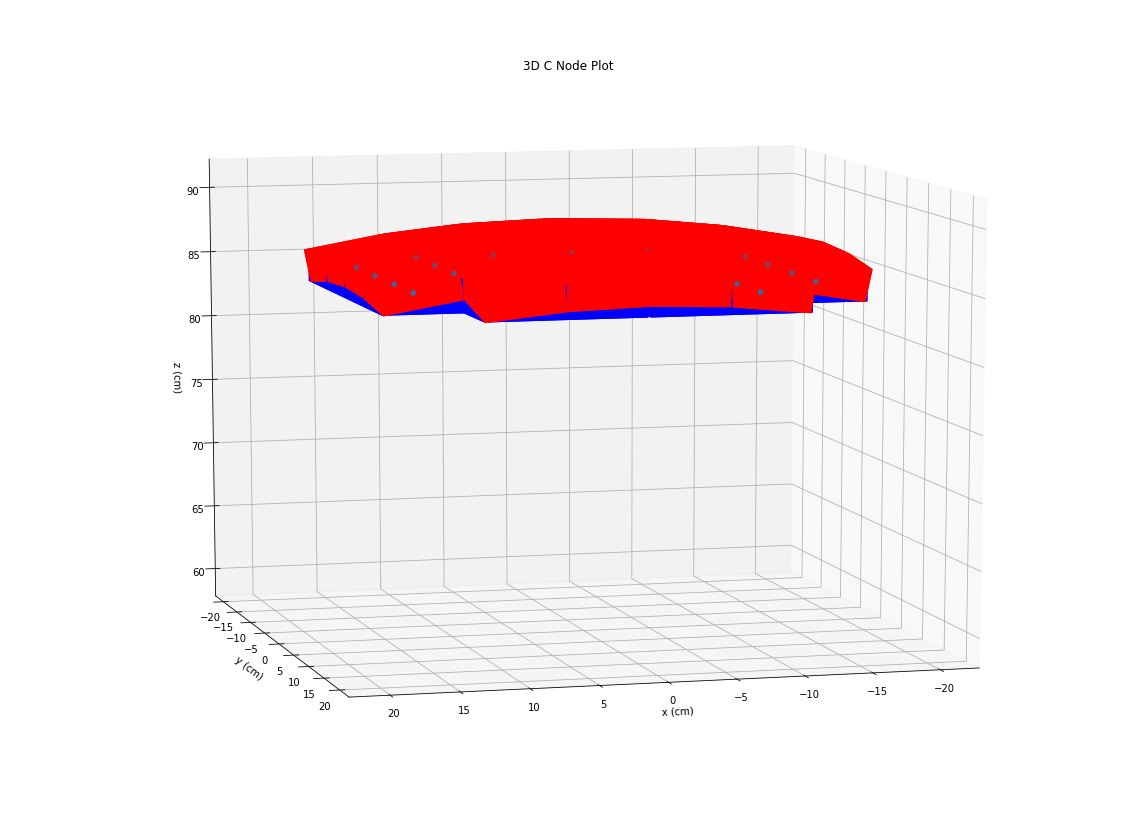

In [6]:
interact(f,r = (0, 90, 0.5), r2 = (60,90, 0.5), s = (5.6, 6.2, 0.1), Spin=(0,360,0.5), 
         Elevation=(-90,90,0.5), ToScale=True, alpha = (0,1,0.01),
        alpha2 = (0,1,0.01))

In [7]:
n = [-3,-2,-1,1,2,3]
a = [1,2,3,4,
       0,1,2,3,4,5,
       0,1,4,5,
       0,1,4,5,
       0,1,2,3,4,5,
       1,2,3,4]

b = [5,5,5,5,
       4,4,4,4,4,4,
       3,3,3,3,
       2,2,2,2,
       1,1,1,1,1,1,
       0,0,0,0]
grid = [(n[i],n[j]) for i,j in zip(a,b)]

def f2(Elevation=10, Spin=75, i = 0):
    
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")
    ax.set_zlabel("z (cm)")
    a, b, g, xcf, ycf, zcf = conc(r,s)
    box = boxmakr((0,0,75), (0,0,0), t = 2.5, clr = 'blue', alp=1)
    boxr = boxmakr((xcf[i],ycf[i],zcf[i]),(np.pi/180*a[i],np.pi/180*b[i],np.pi/180*g[i]), t = 2.5, alp=1)
    print("Node       : (%11f,%11f,%11f)" % (xcf[i],ycf[i],zcf[i]))
    print("Euler      : (%11f,%11f,%11f)" % (a[i],b[i],g[i]))
    print("Grid Index :", grid[i])
    ax.add_collection3d(box)
    ax.add_collection3d(boxr)
    for i in range(28):
        boxr2 = boxmakr((xcf[i],ycf[i],zcf[i]),(np.pi/180*a[i],np.pi/180*b[i],np.pi/180*g[i]),t = 2.5, alp=0.05)
        ax.add_collection3d(boxr2)
    ax.scatter(xcf,ycf,zcf)
    ax.auto_scale_xyz([-20, 20], [-20, 20], [70, 100])
    ax.view_init(elev=Elevation, azim=Spin)

Node       : (  -9.037281,  15.014369,  85.727162)
Euler      : ( 211.044106,  11.553250,-211.044106)
Grid Index : (-2, 3)


<function __main__.f2>

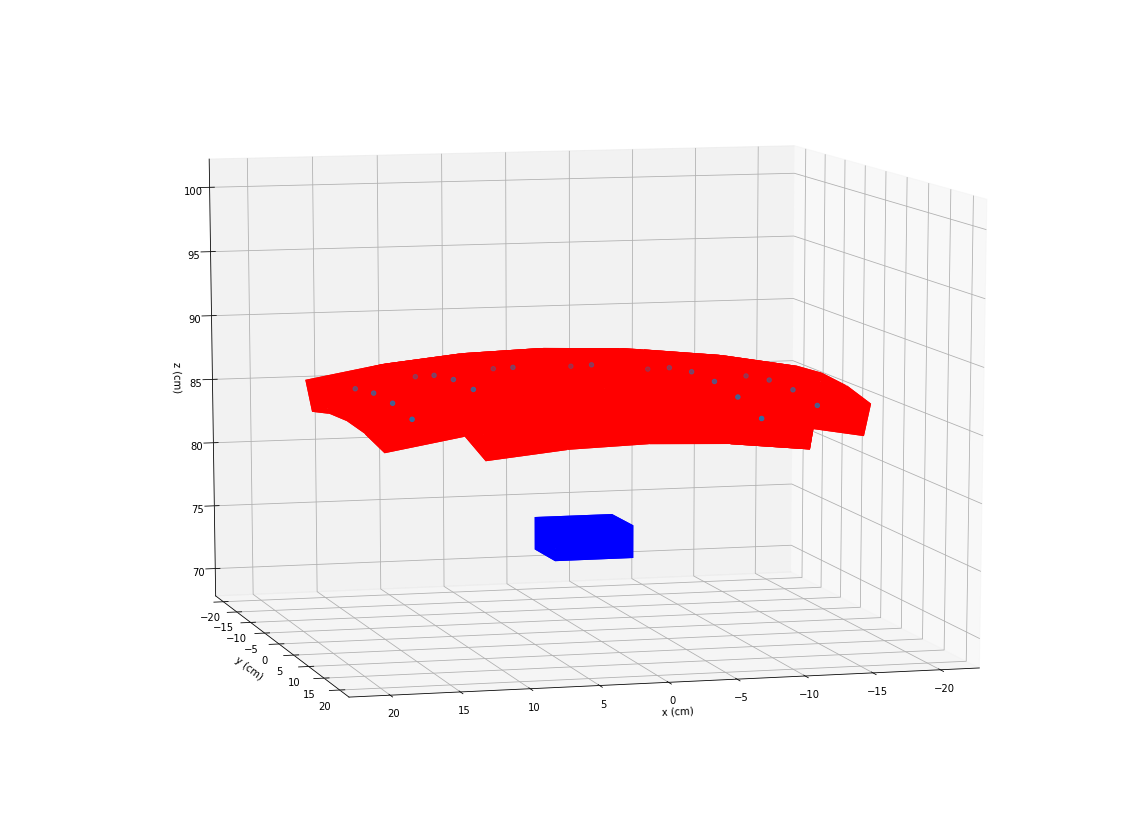

In [8]:
interact(f2, Spin=(0,360,0.5), Elevation=(-90,90,0.5), i = (0,27,1))

In [9]:
Rx = lambda ang: np.array([[1,0,0],[0,np.cos(ang), -np.sin(ang)],[0,np.sin(ang),np.cos(ang)]])
Ry = lambda ang: np.array([[np.cos(ang),0,np.sin(ang)],[0,1,0],[-np.sin(ang),0,np.cos(ang)]])
Rz = lambda ang: np.array([[np.cos(ang), -np.sin(ang),0],[np.sin(ang),np.cos(ang),0],[0,0,1]])

def makedetectors(cp = (0,0,0), ea = (np.pi/4, np.pi/4, -np.pi/4), clrm = "grey", clrq = 'cyan', alpm = 0.75, alpq = 0.25):
    t = 4
    s = 5.9
    q = 5.3
    #making a box
    a = np.array([  -s/2,t/2       ,-s/2])
    b = np.array([  +s/2,t/2       ,-s/2])
    c = np.array([  +s/2,t/2       ,+s/2])
    d = np.array([  -s/2,t/2       ,+s/2])
    e = np.array([  -s/2,t/2-0.70*t,-s/2])
    f = np.array([  +s/2,t/2-0.70*t,-s/2])
    g = np.array([  +s/2,t/2-0.70*t,+s/2])
    h = np.array([  -s/2,t/2-0.70*t,+s/2])
    aq = np.array([ -q/2,t/2-0.70*t,-q/2])
    bq = np.array([ +q/2,t/2-0.70*t,-q/2])
    cq = np.array([ +q/2,t/2-0.70*t,+q/2])
    dq = np.array([ -q/2,t/2-0.70*t,+q/2])
    eq = np.array([ -q/2,-t/2      ,-q/2])
    fq = np.array([ +q/2,-t/2      ,-q/2])
    gq = np.array([ +q/2,-t/2      ,+q/2])
    hq = np.array([ -q/2,-t/2      ,+q/2])
    aq2 = np.array([0   ,t/2-0.70*t,-q/2])
    bq2 = np.array([+q/2,t/2-0.70*t,0   ])
    cq2 = np.array([0   ,t/2-0.70*t,+q/2])
    dq2 = np.array([-q/2,t/2-0.70*t,0   ])
    eq2 = np.array([0   ,-t/2      ,-q/2])
    fq2 = np.array([+q/2,-t/2      ,0   ])
    gq2 = np.array([0   ,-t/2      ,+q/2])
    hq2 = np.array([-q/2,-t/2      ,0   ])
    q01 = np.array([0   ,t/2-0.70*t,0   ])
    q02 = np.array([0   ,-t/2      ,0   ])
    
    
    
    #setting up rotation matrices
    Z1 = Ry(ea[0])
    X2 = Rx(ea[1])
    Z2 = Ry(ea[2])
    
    """
    a = np.matmul(R,a)
    b = np.matmul(R,b)
    c = np.matmul(R,c)
    d = np.matmul(R,d)
    e = np.matmul(R,e)
    f = np.matmul(R,f)
    g = np.matmul(R,g)
    h = np.matmul(R,h)
    
    """

    #Rotating box vertices
    
    #alpha
    a = np.matmul(Z1,a)
    b = np.matmul(Z1,b)
    c = np.matmul(Z1,c)
    d = np.matmul(Z1,d)
    e = np.matmul(Z1,e)
    f = np.matmul(Z1,f)
    g = np.matmul(Z1,g)
    h = np.matmul(Z1,h)
    aq = np.matmul(Z1,aq)
    bq = np.matmul(Z1,bq)
    cq = np.matmul(Z1,cq)
    dq = np.matmul(Z1,dq)
    eq = np.matmul(Z1,eq)
    fq = np.matmul(Z1,fq)
    gq = np.matmul(Z1,gq)
    hq = np.matmul(Z1,hq)
    aq2 = np.matmul(Z1,aq2)
    bq2 = np.matmul(Z1,bq2)
    cq2 = np.matmul(Z1,cq2)
    dq2 = np.matmul(Z1,dq2)
    eq2 = np.matmul(Z1,eq2)
    fq2 = np.matmul(Z1,fq2)
    gq2 = np.matmul(Z1,gq2)
    hq2 = np.matmul(Z1,hq2)
    q01 = np.matmul(Z1,q01)
    q02 = np.matmul(Z1,q02)
    
    #beta
    a = np.matmul(X2,a)
    b = np.matmul(X2,b)
    c = np.matmul(X2,c)
    d = np.matmul(X2,d)
    e = np.matmul(X2,e)
    f = np.matmul(X2,f)
    g = np.matmul(X2,g)
    h = np.matmul(X2,h)
    aq = np.matmul(X2,aq)
    bq = np.matmul(X2,bq)
    cq = np.matmul(X2,cq)
    dq = np.matmul(X2,dq)
    eq = np.matmul(X2,eq)
    fq = np.matmul(X2,fq)
    gq = np.matmul(X2,gq)
    hq = np.matmul(X2,hq)
    aq2= np.matmul(X2,aq2)
    bq2= np.matmul(X2,bq2)
    cq2= np.matmul(X2,cq2)
    dq2= np.matmul(X2,dq2)
    eq2= np.matmul(X2,eq2)
    fq2= np.matmul(X2,fq2)
    gq2= np.matmul(X2,gq2)
    hq2= np.matmul(X2,hq2)
    q01= np.matmul(X2,q01)
    q02= np.matmul(X2,q02)
    

    
    #gamma
    a = np.matmul(Z2,a)
    b = np.matmul(Z2,b)
    c = np.matmul(Z2,c)
    d = np.matmul(Z2,d)
    e = np.matmul(Z2,e)
    f = np.matmul(Z2,f)
    g = np.matmul(Z2,g)
    h = np.matmul(Z2,h)
    aq = np.matmul(Z2,aq)
    bq = np.matmul(Z2,bq)
    cq = np.matmul(Z2,cq)
    dq = np.matmul(Z2,dq)
    eq = np.matmul(Z2,eq)
    fq = np.matmul(Z2,fq)
    gq = np.matmul(Z2,gq)
    hq = np.matmul(Z2,hq)
    aq2 = np.matmul(Z2,aq2)
    bq2 = np.matmul(Z2,bq2)
    cq2 = np.matmul(Z2,cq2)
    dq2 = np.matmul(Z2,dq2)
    eq2 = np.matmul(Z2,eq2)
    fq2 = np.matmul(Z2,fq2)
    gq2 = np.matmul(Z2,gq2)
    hq2 = np.matmul(Z2,hq2)
    q01 = np.matmul(Z2,q01)
    q02 = np.matmul(Z2,q02)
    
    if cp[1] < 0:
        a  *=-1
        b  *=-1
        c  *=-1
        d  *=-1
        e  *=-1
        f  *=-1
        g  *=-1
        h  *=-1
        aq *=-1
        bq *=-1
        cq *=-1
        dq *=-1
        eq *=-1
        fq *=-1
        gq *=-1
        hq *=-1
        aq2*=-1
        bq2*=-1
        cq2*=-1
        dq2*=-1
        eq2*=-1
        fq2*=-1
        gq2*=-1
        hq2*=-1
        q01*=-1
        q02*=-1
    
    #positioning box at center point
    a+=cp
    b+=cp
    c+=cp
    d+=cp
    e+=cp
    f+=cp
    g+=cp
    h+=cp
    aq+=cp
    bq+=cp
    cq+=cp
    dq+=cp
    eq+=cp
    fq+=cp
    gq+=cp
    hq+=cp
    aq2+=cp
    bq2+=cp
    cq2+=cp
    dq2+=cp
    eq2+=cp
    fq2+=cp
    gq2+=cp
    hq2+=cp
    q01+=cp
    q02+=cp
    
    
     
    boxm = [[a,b,c,d],
           [f,b,c,g],
           [g,c,d,h],
           [h,d,a,e],
           [e,a,b,f],
           [e,f,g,h]]
    boxq = [[aq,aq2,q01,dq2],
            [bq,bq2,q01,aq2],
            [cq,cq2,q01,bq2],
            [dq,dq2,q01,cq2],
            [eq,aq,aq2,eq2],
            [eq2,aq2,bq,fq],
            [fq,bq,bq2,fq2],
            [fq2,bq2,cq,gq],
            [gq,cq,cq2,gq2],
            [gq2,cq2,dq,hq],
            [hq,dq,dq2,hq2],
            [hq2,dq2,aq,eq],
           [eq,eq2,q02,hq2],
           [fq,fq2,q02,eq2],
           [gq,gq2,q02,fq2],
           [hq,hq2,q02,gq2]]
    
    collectionm = Poly3DCollection(boxm) #mcp
    collectionq = Poly3DCollection(boxq) #quartz element
    collectionm.set_facecolor(clrm)
    collectionq.set_facecolor(clrq)
    collectionm.set_edgecolor("k")
    collectionq.set_edgecolor("grey")
    collectionm.set_alpha(alpm)
    collectionq.set_alpha(alpq)
    collectionq.set_hatch("//")
    collectionm.set_zsort("min")
    collectionq.set_zsort("min")
    return collectionm, collectionq

In [10]:
defaultspin = 240
defaultelevation = 15
def f3(r = 85.5, s = 5.9, Spin = defaultspin, Elevation = defaultelevation, ToScale=False, bg = False, flipc = True, alpha = 1, zoom = 0):
    fig = plt.figure(figsize=(30,15))
    axc = fig.add_subplot(121, projection='3d')
    axc.set_xlabel("x (cm)")
    axc.set_ylabel("z (cm)")
    axc.set_zlabel("y (cm)")
    
    axa = fig.add_subplot(122, projection='3d')
    axa.set_xlabel("x (cm)")
    axa.set_ylabel("z (cm)")
    axa.set_zlabel("y (cm)")
    
    #xc = np.array([-8.95, -3.05, 3.05, 8.95, 
    #               -14.85, -8.95, -3.05, 3.05,
    #               8.95,  14.85,-14.85, -8.95, 
    #               8.95, 14.85, -14.85, -8.95, 
    #               8.95, 14.85, -14.85,-8.95,
    #               -3.05, 3.05, 8.95, 14.85, 
    #               -8.95, -3.05, 3.05, 8.95])
#
    #yc = np.array([14.85, 14.85,14.85,14.85,
    #               8.95,8.95,8.95,8.95,8.95,8.95,
    #               3.05, 3.05,3.05,3.05,
    #               -3.05,-3.05,-3.05,-3.05,
    #               -8.95,-8.95,-8.95,-8.95,-8.95,-8.95,
    #               -14.85,-14.85,-14.85,-14.85])
#
    #zc = np.ones(28)*r
    
    
    xa = np.array([-11.8, -5.9, 0, 5.9, 11.8, 
                   -11.8, -5.9, 0, 5.9, 11.8,
                   -12.8, -6.9, 6.9, 12.8, 
                   -11.8, -5.9, 0, 5.9, 11.8,
                   -11.8, -5.9, 0, 5.9, 11.8])
  
    ya = np.array([11.9, 11.9, 12.9, 11.9, 11.9,
                   6.0,   6.0,  7.0, 6.0,  6.0,
                   -0.1, -0.1, 0.1, 0.1,
                   -6.0, -6.0, -7.0, -6.0, -6.0,
                   -11.9, -11.9, -12.9,  -11.9, -11.9])

    za = np.ones(24)*325.5

    #zc = np.ones(28)*r2

    a, b, g, xcf, ycf, zcf = conc(r,s)

    
    #vectors = np.array( [[xcf[i],ycf[i],zcf[i],xc[i],yc[i],r2] 
     #                    for i in range(xcf.size)]) 
    #X,Y,Z,U,V,W = zip(*vectors)
    
    #ax.scatter(xcf,ycf,zcf,c="r")
    #ax.scatter(xc,yc,zc)
    #ax.quiver(X,Y,Z,U,V,W,length=2,color="g")
    #Change the aspect ratio
    
    ls = 20 - zoom
    if flipc != False:
        ccenter = -85.5
    else:
        ccenter = 85.5
    acenter = 325
    if ToScale == True:
        axc.set_xlim(left=-ls, right = ls)
        axc.set_ylim(bottom=ccenter-ls, top = ccenter+ls)
        axc.set_zlim(bottom=-ls, top = ls)
        
        #axc.auto_scale_xyz( [-ls, ls],[ccenter - ls, ccenter + ls], [-ls, ls])
    for i in range(0,len(xcf)):
        if flipc != False:
            mcp, qr = makedetectors((xcf[i],-1*zcf[i],ycf[i]), (np.pi/180*a[i],np.pi/180*b[i],np.pi/180*g[i]), alpm = alpha, alpq = alpha-0.25)
        else:
            mcp, qr = makedetectors((xcf[i],zcf[i],ycf[i]), (np.pi/180*a[i],-np.pi/180*b[i],np.pi/180*g[i]), alpm = alpha, alpq = alpha-0.25)
        
        #box2 = makedetectors((xc[i],yc[i],zc[i]), (0,0,0), clrm = 'blue')
        axc.add_collection3d(qr)
        axc.add_collection3d(mcp)
        #ax.add_collection3d(box2)
        
    if ToScale == True:
        axa.set_xlim(left=-ls, right = ls)
        axa.set_ylim(bottom=acenter-ls, top = acenter+ls)
        axa.set_zlim(bottom=-ls, top = ls)
        #axa.auto_scale_xyz([-ls, ls],[acenter - ls, acenter + ls], [-ls, ls])
    for i in range(0,len(xa)):
        mcp, qr = makedetectors((xa[i],za[i],ya[i]), (0,0,0), alpm = alpha, alpq = alpha-0.25)
        axa.add_collection3d(mcp)
        axa.add_collection3d(qr)
    axc.view_init(elev=Elevation, azim=Spin)
    axa.view_init(elev=Elevation, azim=Spin)
    axc._axis3don = bg
    axa._axis3don = bg

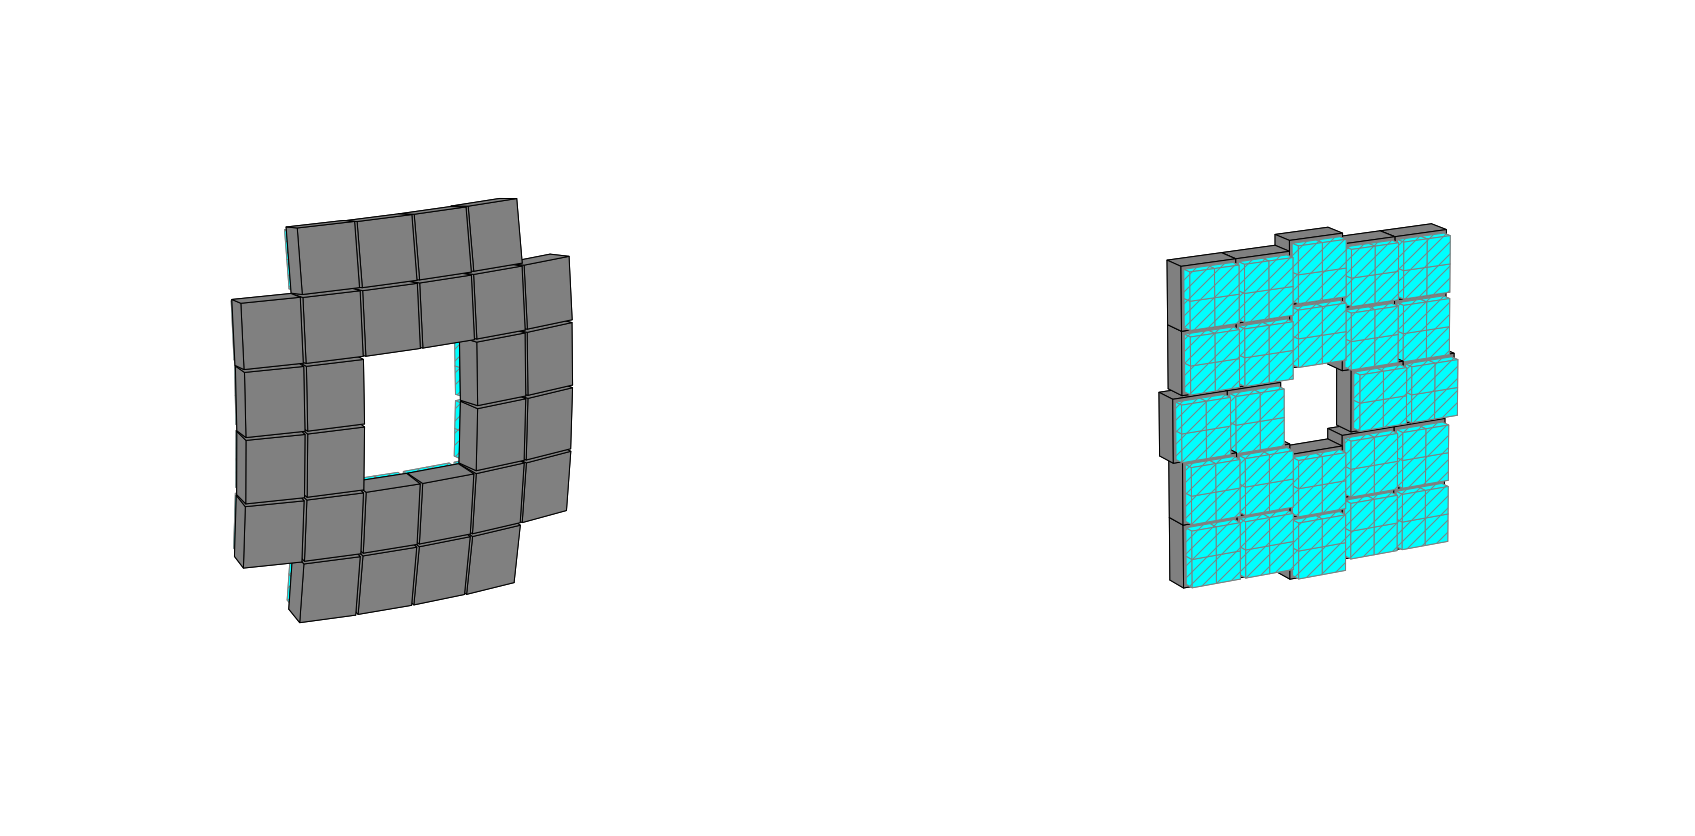

In [11]:
interactive(f3,r = (0, 90, 0.5), s = (5, 7, 0.1), Spin=(0,360,0.5), 
         Elevation=(-90,90,0.5), ToScale=True, bg = False, flipc = True, alpha = (0.5,1,0.01), zoom = (0,10, 0.1))

In [12]:
def f4(r = 85,Spin = defaultspin, Elevation = defaultelevation, ToScale=False, alpha = 1):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("z (cm)")
    ax.set_ylabel("y (cm)")
    ax.set_zlabel("x (cm)")
    xc = np.array([-8.95, -3.05, 3.05, 8.95, 
                   -14.85, -8.95, -3.05, 3.05,
                   8.95,  14.85,-14.85, -8.95, 
                   8.95, 14.85, -14.85, -8.95, 
                   8.95, 14.85, -14.85,-8.95,
                   -3.05, 3.05, 8.95, 14.85, 
                   -8.95, -3.05, 3.05, 8.95])

    yc = np.array([14.85, 14.85,14.85,14.85,
                   8.95,8.95,8.95,8.95,8.95,8.95,
                   3.05, 3.05,3.05,3.05,
                   -3.05,-3.05,-3.05,-3.05,
                   -8.95,-8.95,-8.95,-8.95,-8.95,-8.95,
                   -14.85,-14.85,-14.85,-14.85])

    zc = np.ones(28)*r

    a, b, g, xcf, ycf, zcf = conc(r,s)

    
    #vectors = np.array( [[xcf[i],ycf[i],zcf[i],xc[i],yc[i],r2] 
     #                    for i in range(xcf.size)]) 
    #X,Y,Z,U,V,W = zip(*vectors)
    
    #ax.scatter(xcf,ycf,zcf,c="r")
    #ax.scatter(xc,yc,zc)
    #ax.quiver(X,Y,Z,U,V,W,length=2,color="g")
    #Change the aspect ratio
    if ToScale == True:
        ax.auto_scale_xyz( [-20, 20],[60, 100],[-20, 20])
    for i in range(0,len(xcf)):
        mcp, qr = makedetectors((xc[i],zc[i],yc[i]), (0,0,0), alpm = alpha, alpq = alpha-0.25)
        ax.add_collection3d(mcp)
        ax.add_collection3d(qr)
    ax.view_init(elev=Elevation, azim=Spin)

<function __main__.f4>

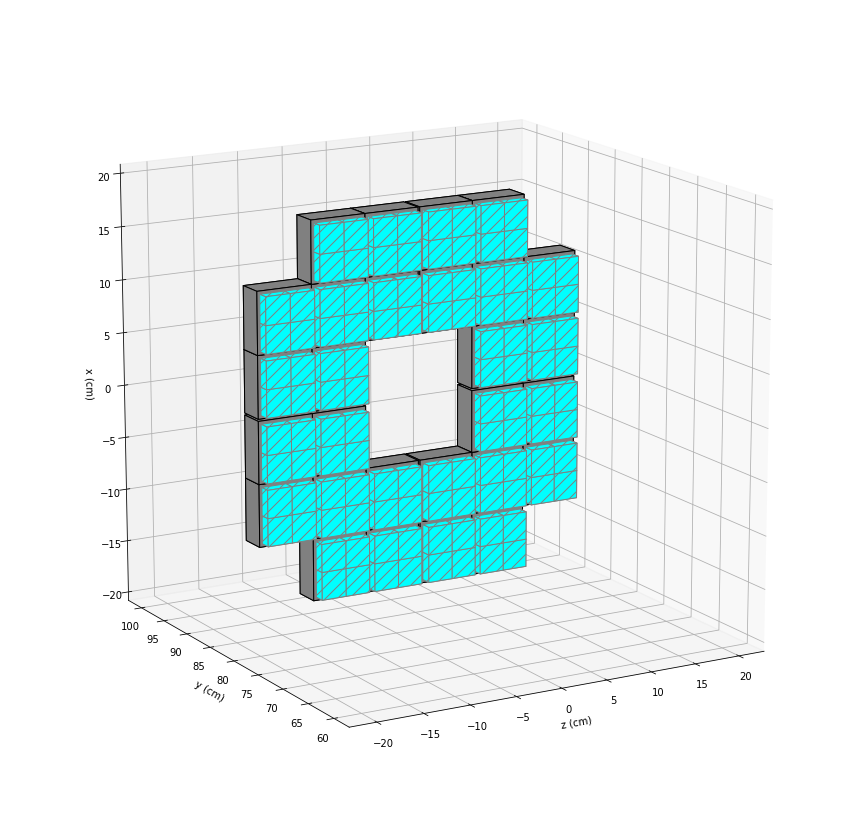

In [13]:
interact(f4,r = (0, 90, 0.5), Spin=(0,360,0.5), 
         Elevation=(-90,90,0.5), ToScale=True, alpha = (0.5,1,0.01))

In [14]:
def makesupport(cp = (0,0,0), ea = (np.pi/4, np.pi/4, -np.pi/4), side = 6.634702, clr = "lightgrey", alp = 1):
    s = side
    sd = s - 5.9
    sq = s - 5.3
    t = 4
    theta = np.arctan(5.9/85.5)
    bc = (t+2)*np.tan(theta)/2
    
    a  = np.array([  -s/2 - bc  ,t/2 + 1   ,-s/2 - bc  ])
    b  = np.array([  +s/2 + bc  ,t/2 + 1   ,-s/2 - bc  ])
    c  = np.array([  +s/2 + bc  ,t/2 + 1   ,+s/2 + bc  ])
    d  = np.array([  -s/2 - bc  ,t/2 + 1   ,+s/2 + bc  ])
    e  = np.array([  -s/2       ,-t/2      ,-s/2       ])
    f  = np.array([  +s/2       ,-t/2      ,-s/2       ])
    g  = np.array([  +s/2       ,-t/2      ,+s/2       ])
    h  = np.array([  -s/2       ,-t/2      ,+s/2       ])
    ai = np.array([  -s/2 + sd/2,t/2 + 1   ,-s/2 + sd/2])
    bi = np.array([  +s/2 - sd/2,t/2 + 1   ,-s/2 + sd/2])
    ci = np.array([  +s/2 - sd/2,t/2 + 1   ,+s/2 - sd/2])
    di = np.array([  -s/2 + sd/2,t/2 + 1   ,+s/2 - sd/2])
    ei = np.array([  -s/2 + sq/2,-t/2      ,-s/2 + sq/2])
    fi = np.array([  +s/2 - sq/2,-t/2      ,-s/2 + sq/2])
    gi = np.array([  +s/2 - sq/2,-t/2      ,+s/2 - sq/2])
    hi = np.array([  -s/2 + sq/2,-t/2      ,+s/2 - sq/2])
    am = np.array([  -s/2 + sd/2,t/2-0.70*t,-s/2 + sd/2])
    bm = np.array([  +s/2 - sd/2,t/2-0.70*t,-s/2 + sd/2])
    cm = np.array([  +s/2 - sd/2,t/2-0.70*t,+s/2 - sd/2])
    dm = np.array([  -s/2 + sd/2,t/2-0.70*t,+s/2 - sd/2])
    em = np.array([  -s/2 + sq/2,t/2-0.70*t,-s/2 + sq/2])
    fm = np.array([  +s/2 - sq/2,t/2-0.70*t,-s/2 + sq/2])
    gm = np.array([  +s/2 - sq/2,t/2-0.70*t,+s/2 - sq/2])
    hm = np.array([  -s/2 + sq/2,t/2-0.70*t,+s/2 - sq/2])
    
    #setting up rotation matrices
    Z1 = Ry(ea[0])
    X2 = Rx(ea[1])
    Z2 = Ry(ea[2])
    
    #Rotating box vertices
    
    #alpha
    a = np.matmul(Z1,a)
    b = np.matmul(Z1,b)
    c = np.matmul(Z1,c)
    d = np.matmul(Z1,d)
    e = np.matmul(Z1,e)
    f = np.matmul(Z1,f)
    g = np.matmul(Z1,g)
    h = np.matmul(Z1,h)
    ai = np.matmul(Z1,ai)
    bi = np.matmul(Z1,bi)
    ci = np.matmul(Z1,ci)
    di = np.matmul(Z1,di)
    ei = np.matmul(Z1,ei)
    fi = np.matmul(Z1,fi)
    gi = np.matmul(Z1,gi)
    hi = np.matmul(Z1,hi)
    am = np.matmul(Z1,am)
    bm = np.matmul(Z1,bm)
    cm = np.matmul(Z1,cm)
    dm = np.matmul(Z1,dm)
    em = np.matmul(Z1,em)
    fm = np.matmul(Z1,fm)
    gm = np.matmul(Z1,gm)
    hm = np.matmul(Z1,hm)
    
    #beta
    a = np.matmul(X2,a)
    b = np.matmul(X2,b)
    c = np.matmul(X2,c)
    d = np.matmul(X2,d)
    e = np.matmul(X2,e)
    f = np.matmul(X2,f)
    g = np.matmul(X2,g)
    h = np.matmul(X2,h)
    ai = np.matmul(X2,ai)
    bi = np.matmul(X2,bi)
    ci = np.matmul(X2,ci)
    di = np.matmul(X2,di)
    ei = np.matmul(X2,ei)
    fi = np.matmul(X2,fi)
    gi = np.matmul(X2,gi)
    hi = np.matmul(X2,hi)
    am= np.matmul(X2,am)
    bm= np.matmul(X2,bm)
    cm= np.matmul(X2,cm)
    dm= np.matmul(X2,dm)
    em= np.matmul(X2,em)
    fm= np.matmul(X2,fm)
    gm= np.matmul(X2,gm)
    hm= np.matmul(X2,hm)

    #gamma
    a = np.matmul(Z2,a)
    b = np.matmul(Z2,b)
    c = np.matmul(Z2,c)
    d = np.matmul(Z2,d)
    e = np.matmul(Z2,e)
    f = np.matmul(Z2,f)
    g = np.matmul(Z2,g)
    h = np.matmul(Z2,h)
    ai = np.matmul(Z2,ai)
    bi = np.matmul(Z2,bi)
    ci = np.matmul(Z2,ci)
    di = np.matmul(Z2,di)
    ei = np.matmul(Z2,ei)
    fi = np.matmul(Z2,fi)
    gi = np.matmul(Z2,gi)
    hi = np.matmul(Z2,hi)
    am = np.matmul(Z2,am)
    bm = np.matmul(Z2,bm)
    cm = np.matmul(Z2,cm)
    dm = np.matmul(Z2,dm)
    em = np.matmul(Z2,em)
    fm = np.matmul(Z2,fm)
    gm = np.matmul(Z2,gm)
    hm = np.matmul(Z2,hm)
    
    a +=cp
    b +=cp
    c +=cp
    d +=cp
    e +=cp
    f +=cp
    g +=cp
    h +=cp
    ai+=cp
    bi+=cp
    ci+=cp
    di+=cp
    ei+=cp
    fi+=cp
    gi+=cp
    hi+=cp
    am+=cp
    bm+=cp
    cm+=cp
    dm+=cp
    em+=cp
    fm+=cp
    gm+=cp
    hm+=cp
    
    house = [[a ,b ,bi,ai], #-
             [b ,c ,ci,bi], # |_ Back Lip
             [c ,d ,di,ci], # |
             [d ,a ,ai,di], #-
             [e ,f ,fi,ei], #-
             [f ,g ,gi,fi], # |_ Front Lip
             [g ,h ,hi,gi], # |
             [h ,e ,ei,hi], #-
             [am,em,fm,bm], #-
             [bm,fm,gm,cm], # |_ Middle Lip
             [cm,gm,hm,dm], # |
             [dm,hm,em,am], #-
             [ai,am,bm,bi], #-
             [bi,bm,cm,ci], # |_ Back Inner Walls
             [ci,cm,dm,di], # |
             [di,dm,am,ai], #-
             [ei,em,fm,fi], #-
             [fi,fm,gm,gi], # |_ Front Inner Walls
             [gi,gm,hm,hi], # |
             [hi,hm,em,ei], #-
             [e ,a ,b ,f ], #-
             [f ,b ,c ,g ], # |_ Outer Walls
             [g ,c ,d ,h ], # |
             [h ,d ,a ,e ]] #-
    w1 = [[e ,a ,b ,f ],
          [a ,b ,bi,ai],
          [e ,f ,fi,ei],
          [am,em,fm,bm],
          [ai,am,bm,bi],
          [ei,em,fm,fi]]
    w2 = [[f ,b ,c ,g ],
          [b ,c ,ci,bi],
          [f ,g ,gi,fi],
          [bm,fm,gm,cm],
          [bi,bm,cm,ci],
          [fi,fm,gm,gi]]
    w3 = [[g ,c ,d ,h ],
          [c ,d ,di,ci],
          [g ,h ,hi,gi],
          [cm,gm,hm,dm],
          [ci,cm,dm,di],
          [gi,gm,hm,hi]]
    w4 = [[h ,d ,a ,e ],
          [d ,a ,ai,di],
          [h ,e ,ei,hi],
          [dm,hm,em,am],
          [di,dm,am,ai],
          [hi,hm,em,ei]]
    
    collw1 = Poly3DCollection(w1)
    collw1.set_facecolor(clr)
    collw1.set_edgecolor("k")
    collw1.set_alpha(alp)
    collw1.set_zsort("max")
    collw2 = Poly3DCollection(w2)
    collw2.set_facecolor(clr)
    collw2.set_edgecolor("k")
    collw2.set_alpha(alp)
    collw2.set_zsort("max")
    collw3 = Poly3DCollection(w3)
    collw3.set_facecolor(clr)
    collw3.set_edgecolor("k")
    collw3.set_alpha(alp)
    collw3.set_zsort("min")
    collw4 = Poly3DCollection(w4)
    collw4.set_facecolor(clr)
    collw4.set_edgecolor("k")
    collw4.set_alpha(alp)
    collw4.set_zsort("min")
    return collw1, collw2, collw3, collw4

In [15]:
defaultspin = 240
defaultelevation = 10
def f5(Spin = defaultspin, Elevation = defaultelevation, ToScale=False, bg = False, alpha = 1, alphah = 1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("z (cm)")
    ax.set_zlabel("y (cm)")
    
    w1, w2, w3, w4 = makesupport((0,0,0), (0,0,0), alp = alphah)
   
    mcp, qr = makedetectors((0,0,0), (0,0,0), alpm = alpha, alpq = alpha-0.5)
    ax.add_collection3d(mcp)
    ax.add_collection3d(qr)
    ax.add_collection3d(w1)
    ax.add_collection3d(w2)
    ax.add_collection3d(w3)
    ax.add_collection3d(w4)

    if ToScale == True:
        ax.auto_scale_xyz([-4,4],[-4,4], [-4,4])
    ax.view_init(elev=Elevation, azim=Spin)
    ax._axis3don = bg

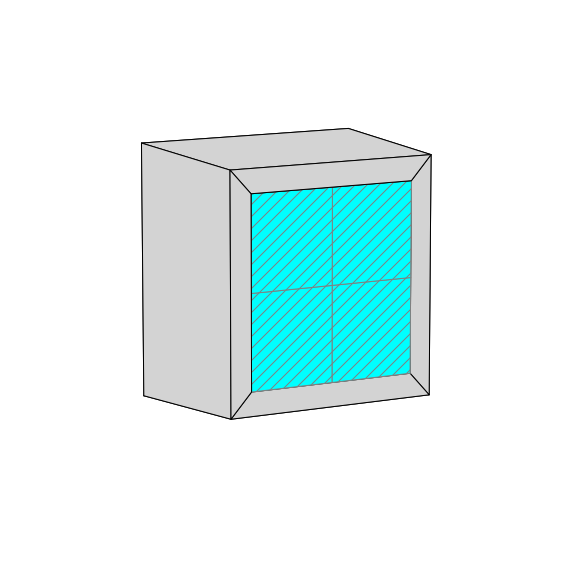

In [16]:
interactive(f5,r = (0, 90, 0.5), Spin=(0,360,0.5), 
         Elevation=(-90,90,0.5), ToScale=True, bg = False, alpha = (0.5,1,0.01), alphah = (0,1,0.01))

In [25]:
defaultspin = 240
defaultelevation = 15
def f6(r = 85.5, sc = 6.634702, sa = 5.9, mcps = True, housing = True, cside = True, aside = False, Spin = defaultspin, Elevation = defaultelevation, ToScale=False, bg = False, alpha = 1, alphah = 0.75):
    fig = plt.figure(figsize=(30,15))
    if cside == True:
        axc = fig.add_subplot(121, projection='3d')
        axc.set_xlabel("x (cm)")
        axc.set_ylabel("z (cm)")
        axc.set_zlabel("y (cm)")
    
    if aside == True:
        axa = fig.add_subplot(122, projection='3d')
        axa.set_xlabel("x (cm)")
        axa.set_ylabel("z (cm)")
        axa.set_zlabel("y (cm)")
    
    #xc = np.array([-8.95, -3.05, 3.05, 8.95, 
    #               -14.85, -8.95, -3.05, 3.05,
    #               8.95,  14.85,-14.85, -8.95, 
    #               8.95, 14.85, -14.85, -8.95, 
    #               8.95, 14.85, -14.85,-8.95,
    #               -3.05, 3.05, 8.95, 14.85, 
    #               -8.95, -3.05, 3.05, 8.95])
#
    #yc = np.array([14.85, 14.85,14.85,14.85,
    #               8.95,8.95,8.95,8.95,8.95,8.95,
    #               3.05, 3.05,3.05,3.05,
    #               -3.05,-3.05,-3.05,-3.05,
    #               -8.95,-8.95,-8.95,-8.95,-8.95,-8.95,
    #               -14.85,-14.85,-14.85,-14.85])
#
    #zc = np.ones(28)*r
    
    
    xa = np.array([-11.8, -5.9, 0, 5.9, 11.8, 
                   -11.8, -5.9, 0, 5.9, 11.8,
                   -12.8, -6.9, 6.9, 12.8, 
                   -11.8, -5.9, 0, 5.9, 11.8,
                   -11.8, -5.9, 0, 5.9, 11.8])
  
    ya = np.array([11.9, 11.9, 12.9, 11.9, 11.9,
                   6.0,   6.0,  7.0, 6.0,  6.0,
                   -0.1, -0.1, 0.1, 0.1,
                   -6.0, -6.0, -7.0, -6.0, -6.0,
                   -11.9, -11.9, -12.9,  -11.9, -11.9])

    za = np.ones(24)*325.5
    
    for i in range(24):
        if(xa[i] > 0.1):
            xa[i]+= (sa-5.9)*np.abs(xa[i])
        if(xa[i] <-0.1):
            xa[i]-= (sa-5.9)*np.abs(xa[i])
        if(ya[i] > 0.1):
            ya[i]+= (sa-5.9)*np.abs(ya[i])
        if(ya[i] <-0.1):
            ya[i]-= (sa-5.9)*np.abs(ya[i])

    #zc = np.ones(28)*r2

    a, b, g, xcf, ycf, zcf = conc(r,sc)

    
    #vectors = np.array( [[xcf[i],ycf[i],zcf[i],xc[i],yc[i],r2] 
     #                    for i in range(xcf.size)]) 
    #X,Y,Z,U,V,W = zip(*vectors)
    
    #ax.scatter(xcf,ycf,zcf,c="r")
    #ax.scatter(xc,yc,zc)
    #ax.quiver(X,Y,Z,U,V,W,length=2,color="g")
    #Change the aspect ratio
    if cside == True:
        if ToScale == True:
            axc.auto_scale_xyz( [-15, 15],[65, 95], [-15, 15])
        for i in range(0,len(xcf)):
            mcp, qr = makedetectors((xcf[i],zcf[i],ycf[i]), (np.pi/180*a[i],-np.pi/180*b[i],np.pi/180*g[i]), alpm = alpha, alpq = alpha-0.25)
            #box2 = makedetectors((xc[i],yc[i],zc[i]), (0,0,0), clrm = 'blue')
            w1, w2, w3, w4 = makesupport((xcf[i],zcf[i],ycf[i]), (np.pi/180*a[i],-np.pi/180*b[i],np.pi/180*g[i]), side = sc, alp = alphah)
            if mcps == True:
                axc.add_collection3d(qr)
                axc.add_collection3d(mcp)
            if housing == True:
                axc.add_collection3d(w1)
                axc.add_collection3d(w2)
                axc.add_collection3d(w3)
                axc.add_collection3d(w4)
            #ax.add_collection3d(box2)
       
    if aside == True:
        if ToScale == True:
            axa.auto_scale_xyz([-15, 15],[305, 335], [-15, 15])
        for i in range(0,len(xa)):
            mcp, qr = makedetectors((xa[i],za[i],ya[i]), (0,0,0), alpm = alpha, alpq = alpha-0.25)
            w1, w2, w3, w4 = makesupport((xa[i],za[i],ya[i]), (0,0,0), side = sa,alp = alphah)
            if mcps == True:
                axa.add_collection3d(mcp)
                axa.add_collection3d(qr)
            if housing == True:
                axa.add_collection3d(w1)
                axa.add_collection3d(w2)
                axa.add_collection3d(w3)
                axa.add_collection3d(w4)
    if cside == True:           
        axc.view_init(elev=Elevation, azim=Spin)
    if aside == True:
        axa.view_init(elev=Elevation, azim=Spin)
    if cside == True:
        axc._axis3don = bg
    if aside == True:
        axa._axis3don = bg

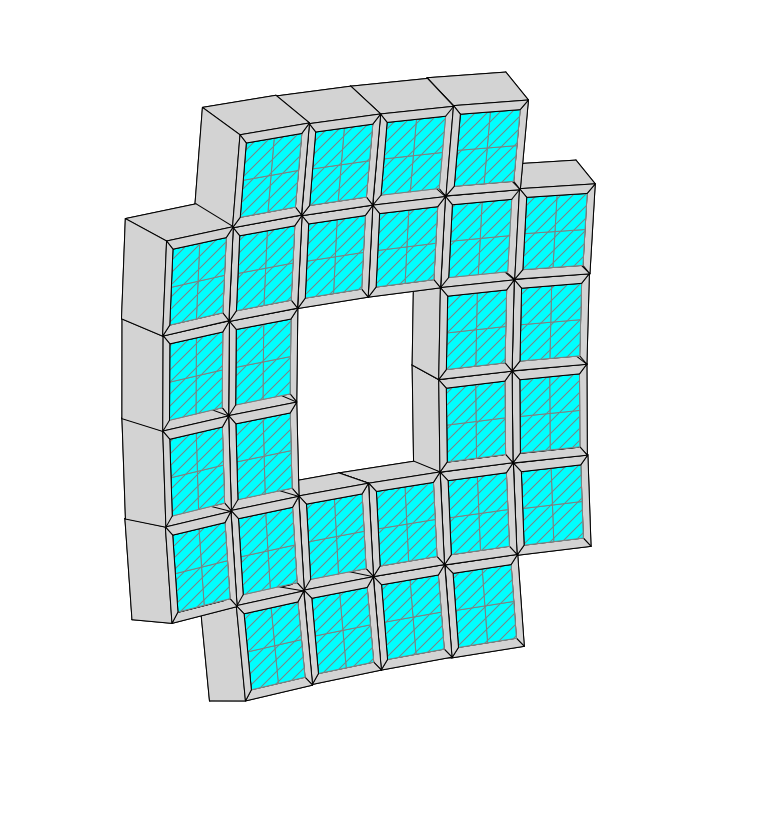

In [26]:
interactive(f6,r = (0, 90, 0.5), sc = (5, 7, 0.1), sa = (5, 7, 0.1), mcps = True, Spin=(0,360,0.5), 
         Elevation=(-90,90,0.5), ToScale=True, bg = False, alpha = (0.25,1,0.01), alphah = (0,1,0.1))

## Determining Eta ranges for different FITC geometries

In [19]:
#v4
s = 5.9
z = 84
x1 = 3.05-s/2
x2 = 8.95-s/2
x3 = 8.95+s/2
x4 = 14.85+s/2
tmin = np.arctan(np.sqrt(x1**2+x2**2)/z)
tmax = np.arctan(np.sqrt(x3**2+x4**2)/z)

In [20]:
etamax = -np.log(np.tan(tmin/2))
etamin = -np.log(np.tan(tmax/2))
print("Minimum Eta : %.6f" % (etamin))
print("Maximum Eta : %.6f" % (etamax))

Minimum Eta : 2.075900
Maximum Eta : 3.333339


In [21]:
#"v5"-"v7"
s = 5.8
r = 80
t = 2*np.arctan(s/2/r)
x1 = r*np.sin(0)
x2 = r*np.sin(t)
x3 = r*np.sin(2*t)
x4 = r*np.sin(3*t)
pho1 = np.sqrt(x1**2+x2**2)
pho2 = np.sqrt(x3**2+x4**2)
tmin = np.arctan(pho1/np.sqrt(r**2-x1**2-x2**2))
tmax = np.arctan(pho2/np.sqrt(r**2-x3**2-x4**2))

In [22]:
etamax = -np.log(np.tan(tmin/2))
etamin = -np.log(np.tan(tmax/2))
print("Minimum Eta : %.3f" % (etamin))
print("Maximum Eta : %.3f" % (etamax))

Minimum Eta : 2.025
Maximum Eta : 3.317


In [23]:
#"v8"
s = 5.9
r = 85.5
t = 2*np.arctan(s/2/r)
x1 = r*np.sin(0)
x2 = r*np.sin(t)
x3 = r*np.sin(2*t)
x4 = r*np.sin(3*t)
pho1 = np.sqrt(x1**2+x2**2)
pho2 = np.sqrt(x3**2+x4**2)
tmin = np.arctan(pho1/np.sqrt(r**2-x1**2-x2**2))
tmax = np.arctan(pho2/np.sqrt(r**2-x3**2-x4**2))

In [24]:
etamax = -np.log(np.tan(tmin/2))
etamin = -np.log(np.tan(tmax/2))
print("Minimum Eta : %.3f" % (etamin))
print("Maximum Eta : %.3f" % (etamax))

Minimum Eta : 2.075
Maximum Eta : 3.367
